# MLB Data Analysis
<!-- ![MLB]( width="500") -->
<img src="https://img.mlbstatic.com/mlb-images/image/private/ar_16:9,g_auto,q_auto:good,w_1024,c_fill,f_jpg,dpr_3.0/mlb/v9d87gj1wrapw3wguheu" width="500"/>


1. Problem definition

2. Acquire data

3. Data cleaning
- Drop 5 infrequent types
- Drop sparse columns
- Drop rows with null values

4. Feature Selection
- Choose k best categorical variables
- Choose k best numerical variables

5. Exploratory Data Analysis
- Is pitch type seperable in 2-D in PC1 & PC2 Space?
- How is release speed differ by pitch name?
- What is the make up of pitches that were thrown harder than 90 miles per hour?
- What is the pitch make up of the pitches move the great deal in the horizontal direction(pfx_x) or vertical direction(pfx_z)
- What pitches associated with low spin rate and high spin rate?
- Does pitcher throw differently based on the opponent(hitter)?
- How does the hitter's count impact what type of pitch is thrown next
- How does the hitter's count impact what is the location of the pitch thrown next


6. Build Model and explain the performance
- Random forest model -> accuracy : 80.7 %
- KNN classifier -> accuracy : 78.7 %

7. Submit the results.

## 1. Probelm definition
> Predict pitch name based on other variables

In [1]:
# Data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

import math
import os


In [2]:
# %pwd
# os.chdir('/Users/kylecamlic/Documents')
# %pwd

## 2. Acquire Data

In [3]:

df = pd.read_csv("statcast_2017.csv")


In [4]:
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,2265,FC,2017-10-01,91.9,-1.19,5.99,"Osuna, Roberto",595885,532077,field_out,hit_into_play,NaN,NaN,NaN,NaN,1.0,Greg Bird pops out to shortstop Richard Urena.,R,L,R,NYY,TOR,X,6.0,popup,3,2,2017,-0.06,1.54,-0.48,3.25,NaN,NaN,NaN,2,9,Bot,108.43,103.14,NaN,NaN,607257.0,NaN,NaN,1.930940,-133.402168,-4.296699,-1.171849,29.813786,-13.377620,3.29,1.48,235.0,81.3,51.0,91.0,2422.0,5.9,492528,532077,607257.0,475253.0,572365.0,446381.0,620446.0,485567.0,606192.0,608701.0,54.56,0.033,0.042,0.0,1.0,0.0,0.0,3.0,63,6,Cutter,1,2,1,2,2,1,1,2,Infield shift,Strategic,183.0,-0.044,-0.124
1,2350,FC,2017-10-01,91.8,-1.08,6.18,"Osuna, Roberto",595885,532077,NaN,foul,NaN,NaN,NaN,NaN,3.0,Greg Bird pops out to shortstop Richard Urena.,R,L,R,NYY,TOR,S,NaN,NaN,3,1,2017,0.31,1.17,0.55,2.88,NaN,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,607257.0,NaN,NaN,3.443835,-133.448994,-4.998474,3.013840,26.852669,-17.455348,3.29,1.48,NaN,NaN,NaN,91.5,2415.0,6.0,492528,532077,607257.0,475253.0,572365.0,446381.0,620446.0,485567.0,606192.0,608701.0,54.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63,5,Cutter,1,2,1,2,2,1,1,2,Infield shift,Strategic,164.0,-0.044,-0.035
2,2397,FF,2017-10-01,94.7,-0.62,6.34,"Osuna, Roberto",595885,532077,NaN,ball,NaN,NaN,NaN,NaN,12.0,Greg Bird pops out to shortstop Richard Urena.,R,L,R,NYY,TOR,B,NaN,NaN,2,1,2017,-0.27,1.84,1.54,2.76,NaN,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,607257.0,NaN,NaN,6.175603,-137.339686,-7.658337,-4.705145,30.210926,-7.569305,3.44,1.68,NaN,NaN,NaN,94.2,2450.0,6.1,492528,532077,607257.0,475253.0,572365.0,446381.0,620446.0,485567.0,606192.0,608701.0,54.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63,4,4-Seam Fastball,1,2,1,2,2,1,1,2,Infield shift,Strategic,189.0,-0.044,0.038
3,2485,CH,2017-10-01,82.8,-0.99,6.06,"Osuna, Roberto",595885,532077,NaN,ball,NaN,NaN,NaN,NaN,13.0,Greg Bird pops out to shortstop Richard Urena.,R,L,R,NYY,TOR,B,NaN,NaN,1,1,2017,-1.27,1.38,-0.21,0.80,NaN,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,607257.0,NaN,NaN,4.219281,-120.061310,-8.130244,-13.056935,22.889681,-17.553809,3.45,1.71,NaN,NaN,NaN,82.6,2063.0,6.3,492528,532077,607257.0,475253.0,572365.0,446381.0,620446.0,485567.0,606192.0,608701.0,54.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63,3,Changeup,1,2,1,2,2,1,1,2,Infield shift,Strategic,226.0,-0.044,0.020
4,2666,FT,2017-10-01,95.9,-0.89,6.13,"Osuna, Roberto",595885,532077,NaN,ball,NaN,NaN,NaN,NaN,13.0,Greg Bird pops out to shortstop Richard Urena.,R,L,R,NYY,TOR,B,NaN,NaN,0,1,2017,-1.19,1.50,-0.79,0.87,NaN,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,607257.0,NaN,NaN,2.946698,-139.098671,-11.627566,-16.153705,30.503077,-10.366847,3.61,1.77,NaN,NaN,NaN,95.8,2554.0,6.3,492528,532077,607257.0,475253.0,572365.0,446381.0,620446.0,485567.0,606192.0,608701.0,54.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63,2,2-Seam Fastball,1,2,1,2,2,1,1,2,Infield shift,Strategic,221.0,-0.044,0.014


## 3. Data Cleaning

pitch_name     
4-Seam Fastball    0.347745
Slider             0.162316
2-Seam Fastball    0.129517
Changeup           0.099332
Sinker             0.078767
Curveball          0.078671
Cutter             0.053005
Knuckle Curve      0.029668
Split-Finger       0.016476
Knuckleball        0.003685
Forkball           0.000344
Eephus             0.000258
Pitch Out          0.000162
Screwball          0.000054
dtype: float64


<AxesSubplot:xlabel='pitch_name'>

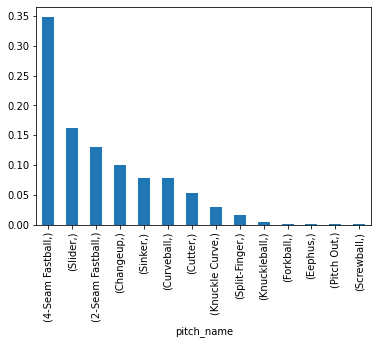

In [5]:
print(df[['pitch_name']].value_counts(normalize= True))
df[['pitch_name']].value_counts(normalize= True).plot(kind = 'bar')

From above we can see 14 types of pitch. For more accurate result, we drop 5 infrequent types, Knuckleball, Forkball, Eephus, Pitch Out and Screwball

In [6]:
#Get rid of Knuckleball, Forkball, Eephus, Pitch Out and Screwball

def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]
    
values = ['Knuckleball','Forkball','Eephus','Pitch Out','Screwball']
print(f'size before removing 5 pitch name {df.shape}')
df = filter_rows_by_values(df,'pitch_name', values)
print(f'size after removing 5 pitch name {df.shape}')

size before removing 5 pitch name (721244, 93)
size after removing 5 pitch name (718011, 93)


In [7]:
# drop columns with high null rate (60%)
print(f"shape of df before dropping high null columns {df.shape}")
df = df.dropna(thresh=df.shape[0]*0.6,how='all',axis=1)
print(f"shape of df after dropping high null columns {df.shape}")

# get rid of all null rows
print(f"size before rows with null value {df.shape}")
df = df.dropna()
print(f"size before rows with null value{df.shape}")

shape of df before dropping high null columns (718011, 93)
shape of df after dropping high null columns (718011, 67)
size before rows with null value (718011, 67)
size before rows with null value(700635, 67)


In [8]:
# change the data type of batter from int to string for future training purpose
df['batter'] = df['batter'].astype("str")

## 4. Feature Selection

In this section, we would like to select variables that has correlation with our target variable.

We split into two part. 

1) Choose K Best categorical variables 
2) Choose K Best numerical variables 

Reference : https://machinelearningmastery.com/chi-squared-test-for-machine-learning/

**Choose K Best Categorical Variables**

Pearson’s Chi-Squared Test

The Chi-Squared test does this for a contingency table, first calculating the expected frequencies for the groups, then determining whether the division of the groups, called the observed frequencies, matches the expected frequencies. When observed frequency is far from the expected frequency, the corresponding term in the sum is large; when the two are close, this term is small. Large values of X^2 indicate that observed and expected frequencies are far apart. Small values of X^2 mean the opposite: observeds are close to expecteds. So X^2 does give a measure of the distance between observed and expected frequencies

The variables are considered independent if the observed and expected frequencies are similar, that the levels of the variables do not interact, are not dependent.

The Pearson’s chi-squared test for independence can be calculated in Python using the chi2_contingency() SciPy function.

For example, a probability of 95% can be used, suggesting that the finding of the test is quite likely given the assumption of the test that the variable is independent. If the statistic is less than or equal to the critical value, we can fail to reject this assumption, otherwise it can be rejected.

We can also interpret the p-value by comparing it to a chosen significance level, which would be 5%, calculated by inverting the 95% probability used in the critical value interpretation.

In [9]:
df_categorical = df.select_dtypes(exclude=["number"])
df_categorical.describe()

,pitch_type,game_date,player_name,batter,description,des,game_type,stand,p_throws,home_team,away_team,type,inning_topbot,pitch_name,if_fielding_alignment,of_fielding_alignment
count,700635,700635,700635,700635,700635,700635,700635,700635,700635,700635,700635,700635,700635,700635,700635,700635
unique,9,179,753,957,12,123247,1,2,2,30,30,3,2,9,3,4
top,FF,2017-09-02,"Verlander, Justin",592450,ball,Khris Davis strikes out swinging.,R,R,R,BOS,BOS,S,Top,4-Seam Fastball,Standard,Standard
freq,248751,5215,3524,2889,237431,644,700635,409812,518327,24705,24316,321429,356439,248751,554768,652508


In [10]:
# add batter ID
df_categorical['batter'] = df.batter.astype(str)

/var/folders/ph/yfqxnlss1ds28x8n8wzmqfg00000gn/T/ipykernel_7211/1831782859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categorical['batter'] = df.batter.astype(str)


We drop the columns that is not contributing to predict pitch_name.

In [11]:
Y_categorical = df_categorical.pitch_name
X_categorical = df_categorical.drop(['des','game_type','pitch_type','pitch_name'], axis = 1)
X_columns = X_categorical.columns


In [12]:
oe = OrdinalEncoder()
oe.fit(X_categorical)
X_categorical = oe.transform(X_categorical)
X_categorical

array([[178., 499., 690., ...,   0.,   0.,   3.],
       [178., 499., 690., ...,   0.,   0.,   3.],
       [178., 499., 690., ...,   0.,   0.,   3.],
       ...,
       [  0., 414., 943., ...,   1.,   1.,   2.],
       [  0., 414., 943., ...,   1.,   1.,   2.],
       [  0., 414., 943., ...,   1.,   1.,   2.]])

In [13]:
# prepare target
le = LabelEncoder()
le.fit(Y_categorical)
Y_categorical = le.transform(Y_categorical)

In [14]:
fs = SelectKBest(score_func=chi2, k="all")
fs.fit(X_categorical, Y_categorical)
print(X_categorical.shape)
X_categorical = fs.transform(X_categorical)


(700635, 12)


Feature game_date: 3102.625799
Feature player_name: 244435.245938
Feature batter: 12348.884340
Feature description: 9247.783960
Feature stand: 2508.282408
Feature p_throws: 1498.419436
Feature home_team: 3677.409632
Feature away_team: 2314.145058
Feature type: 779.396475
Feature inning_topbot: 63.081745
Feature if_fielding_alignment: 147.664196
Feature of_fielding_alignment: 5.743658


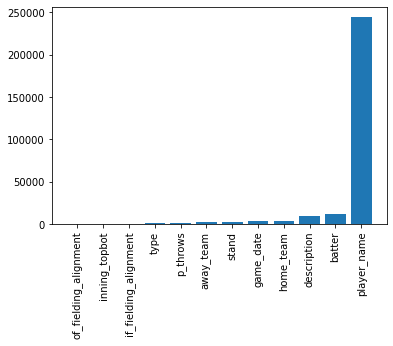

In [15]:
# what are scores for the features
score_dict = {}
for i in range(len(fs.scores_)):
	print(f'Feature {X_columns[i]}: %f' % (fs.scores_[i]))
	score_dict[X_columns[i]] = fs.scores_[i]
	
# plot the scores
score_dict = dict(sorted(score_dict.items(), key=lambda item: item[1]))
plt.bar(score_dict.keys(), score_dict.values())
plt.xticks(rotation = 90)
plt.show()

**Choose K Best Numerical Variables**

ANOVA feature selection for numeric input and categorical output

In [16]:
# Choose X
X_numerical = df.select_dtypes(include=np.number)
Y_numerical = df.pitch_name
print(X_numerical.columns)

Index(['Unnamed: 0', 'release_speed', 'release_pos_x', 'release_pos_z',
       'pitcher', 'zone', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z',
       'plate_x', 'plate_z', 'outs_when_up', 'inning', 'fielder_2', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'at_bat_number',
       'pitch_number', 'home_score', 'away_score', 'bat_score', 'fld_score',
       'post_away_score', 'post_home_score', 'post_bat_score',
       'post_fld_score', 'spin_axis', 'delta_home_win_exp', 'delta_run_exp'],
      dtype='object')


In [17]:
X_numerical = X_numerical.drop(['Unnamed: 0', 'pitcher'], axis = 1)

In [18]:
# Create and fit selector
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_numerical, Y_numerical)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
X_new = X_numerical.iloc[:,cols]
X_new

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,release_speed,release_pos_z,pfx_x,pfx_z,plate_z,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,release_extension,release_pos_y,spin_axis
0,91.9,5.99,-0.06,1.54,3.25,-133.402168,-4.296699,-1.171849,29.813786,-13.377620,91.0,2422.0,5.9,54.56,183.0
1,91.8,6.18,0.31,1.17,2.88,-133.448994,-4.998474,3.013840,26.852669,-17.455348,91.5,2415.0,6.0,54.49,164.0
2,94.7,6.34,-0.27,1.84,2.76,-137.339686,-7.658337,-4.705145,30.210926,-7.569305,94.2,2450.0,6.1,54.37,189.0
3,82.8,6.06,-1.27,1.38,0.80,-120.061310,-8.130244,-13.056935,22.889681,-17.553809,82.6,2063.0,6.3,54.21,226.0
4,95.9,6.13,-1.19,1.50,0.87,-139.098671,-11.627566,-16.153705,30.503077,-10.366847,95.8,2554.0,6.3,54.17,221.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721239,98.4,5.15,-1.28,0.68,1.83,-142.581131,-4.918857,-18.573869,33.201434,-22.306689,96.7,2066.0,5.5,54.92,246.0
721240,84.6,5.39,1.10,-0.17,1.94,-122.821485,-1.341576,10.331882,24.074272,-33.798336,82.3,2194.0,4.7,55.68,74.0
721241,97.3,5.18,-1.34,0.55,1.33,-141.192269,-5.944415,-18.881798,30.681296,-23.942620,96.2,2015.0,5.6,54.80,252.0
721242,95.9,5.48,-1.59,0.84,2.32,-139.217803,-4.486852,-21.233172,30.974374,-20.788933,94.2,2144.0,5.5,55.07,245.0


Feature release_speed: 245271.87340196123
Feature release_pos_z: 3020.8921179306517
Feature pfx_x: 14417.317493035243
Feature pfx_z: 216998.80144434262
Feature plate_z: 12163.929447732784
Feature vy0: 240952.59072991056
Feature vz0: 30804.33385938965
Feature ax: 13091.994370901144
Feature ay: 91718.86561500122
Feature az: 239421.88110344447
Feature effective_speed: 229706.88773162512
Feature release_spin_rate: 72129.49177046007
Feature release_extension: 11259.13459804743
Feature release_pos_y: 11330.133899855335
Feature spin_axis: 16729.61980981074


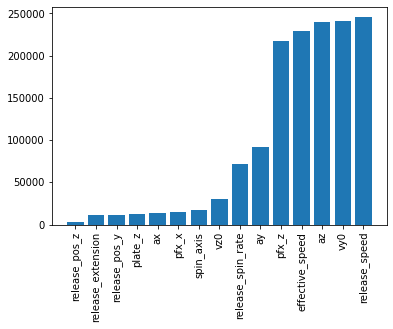

In [19]:
input_features = selector.feature_names_in_
score_dict = {}
for i in range(len(selector.get_feature_names_out())):
    name = selector.get_feature_names_out()[i]
    score = selector.scores_[list(input_features).index(name)]
    score_dict[name] = score
    print(f'Feature {name}: {score}')
# plot the scores
score_dict = dict(sorted(score_dict.items(), key=lambda item: item[1]))
plt.bar(score_dict.keys(), score_dict.values())
plt.xticks(rotation = 90)
plt.show()

## 5.  Exploratory Data Analysis

We will first start with PCA to see whether pitch_name is seperable

In [29]:
# choose the columns that we chose earlier in the meeting
df_pca = X_new
df_pca['pitch_name'] = df.pitch_name

/var/folders/ph/yfqxnlss1ds28x8n8wzmqfg00000gn/T/ipykernel_7211/749443462.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pca['pitch_name'] = df.pitch_name


In [30]:
# drop all the null values before running PCA
print(f"size before droping null values {df_pca.shape}")
df_pca = df_pca.dropna()
print(f"size after droping null values {df_pca.shape}")

size before droping null values (700635, 16)
size after droping null values (700635, 16)


In [32]:
# Choose 1,000 samples and run PCA to see whether there are clusters
df_pca = df_pca.sample(n=1000, random_state=1)
df_pca_x = df_pca.drop('pitch_name', axis = 1)
pca = PCA(n_components=2)
components = pca.fit_transform(df_pca_x)

In [33]:
print(pca.explained_variance_ratio_)

[0.95236827 0.04471499]


In [35]:
components[:,0]
fig = px.scatter(components, x=components[:,0], y=components[:,1], color = df_pca.pitch_name, hover_name = df_pca.pitch_name)
fig.show()

Analyze the release speed by pitch name

In [36]:
#The above result shows the 15 best columns to choose to make a classification model,we predict pitch type
pivot= df.groupby(by = 'pitch_name').mean()['release_speed']
pivot = pivot.sort_values(ascending= False)
pivot

pitch_name
4-Seam Fastball    93.240590
2-Seam Fastball    92.504522
Sinker             91.560689
Cutter             88.460283
Split-Finger       84.700960
Slider             84.521118
Changeup           84.181456
Knuckle Curve      80.429037
Curveball          77.807143
Name: release_speed, dtype: float64

In [37]:
pivot_tab = pd.pivot_table(df,values = 'release_speed', index = df.index,columns= 'pitch_name' )

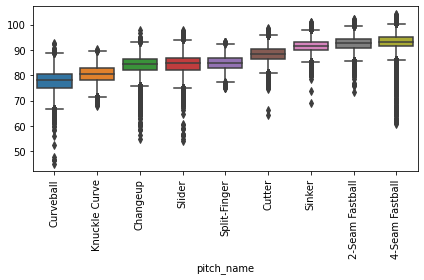

In [38]:
sorted_index = pivot_tab.median().sort_values().index
sorted_index
pivot_tab_sorted=pivot_tab[sorted_index]
sns.boxplot(data = pivot_tab_sorted )
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 90)
plt.tight_layout()

Analyze pitch type of all pitches above 90 miles an hour 

In [39]:
#analyze pitch type of all pitches above 90 miles an hour 
rel_speed_above_90 = df[df.release_speed > 90]
rel_speed_above_90.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,description,zone,des,game_type,stand,p_throws,home_team,away_team,type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,outs_when_up,inning,inning_topbot,fielder_2,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,2265,FC,2017-10-01,91.9,-1.19,5.99,"Osuna, Roberto",595885,532077,hit_into_play,1.0,Greg Bird pops out to shortstop Richard Urena.,R,L,R,NYY,TOR,X,3,2,2017,-0.06,1.54,-0.48,3.25,2,9,Bot,607257.0,1.930940,-133.402168,-4.296699,-1.171849,29.813786,-13.377620,3.29,1.48,91.0,2422.0,5.9,492528,532077,607257.0,475253.0,572365.0,446381.0,620446.0,485567.0,606192.0,608701.0,54.56,63,6,Cutter,1,2,1,2,2,1,1,2,Infield shift,Strategic,183.0,-0.044,-0.124
1,2350,FC,2017-10-01,91.8,-1.08,6.18,"Osuna, Roberto",595885,532077,foul,3.0,Greg Bird pops out to shortstop Richard Urena.,R,L,R,NYY,TOR,S,3,1,2017,0.31,1.17,0.55,2.88,2,9,Bot,607257.0,3.443835,-133.448994,-4.998474,3.013840,26.852669,-17.455348,3.29,1.48,91.5,2415.0,6.0,492528,532077,607257.0,475253.0,572365.0,446381.0,620446.0,485567.0,606192.0,608701.0,54.49,63,5,Cutter,1,2,1,2,2,1,1,2,Infield shift,Strategic,164.0,-0.044,-0.035
2,2397,FF,2017-10-01,94.7,-0.62,6.34,"Osuna, Roberto",595885,532077,ball,12.0,Greg Bird pops out to shortstop Richard Urena.,R,L,R,NYY,TOR,B,2,1,2017,-0.27,1.84,1.54,2.76,2,9,Bot,607257.0,6.175603,-137.339686,-7.658337,-4.705145,30.210926,-7.569305,3.44,1.68,94.2,2450.0,6.1,492528,532077,607257.0,475253.0,572365.0,446381.0,620446.0,485567.0,606192.0,608701.0,54.37,63,4,4-Seam Fastball,1,2,1,2,2,1,1,2,Infield shift,Strategic,189.0,-0.044,0.038
4,2666,FT,2017-10-01,95.9,-0.89,6.13,"Osuna, Roberto",595885,532077,ball,13.0,Greg Bird pops out to shortstop Richard Urena.,R,L,R,NYY,TOR,B,0,1,2017,-1.19,1.50,-0.79,0.87,2,9,Bot,607257.0,2.946698,-139.098671,-11.627566,-16.153705,30.503077,-10.366847,3.61,1.77,95.8,2554.0,6.3,492528,532077,607257.0,475253.0,572365.0,446381.0,620446.0,485567.0,606192.0,608701.0,54.17,63,2,2-Seam Fastball,1,2,1,2,2,1,1,2,Infield shift,Strategic,221.0,-0.044,0.014
5,2780,FF,2017-10-01,96.0,-0.96,6.21,"Osuna, Roberto",595885,532077,called_strike,13.0,Greg Bird pops out to shortstop Richard Urena.,R,L,R,NYY,TOR,S,0,0,2017,-0.71,1.82,-0.94,2.47,2,9,Bot,607257.0,1.588650,-139.347673,-8.248876,-9.411417,28.940518,-7.308381,3.61,1.77,95.2,2478.0,5.8,492528,532077,607257.0,475253.0,572365.0,446381.0,620446.0,485567.0,606192.0,608701.0,54.70,63,1,4-Seam Fastball,1,2,1,2,2,1,1,2,Infield shift,Strategic,203.0,-0.044,-0.018


pitch_name     
4-Seam Fastball    0.619089
2-Seam Fastball    0.216629
Sinker             0.118179
Cutter             0.029404
Slider             0.010941
Changeup           0.005238
Split-Finger       0.000494
Curveball          0.000020
Knuckle Curve      0.000006
dtype: float64


<AxesSubplot:xlabel='pitch_name'>

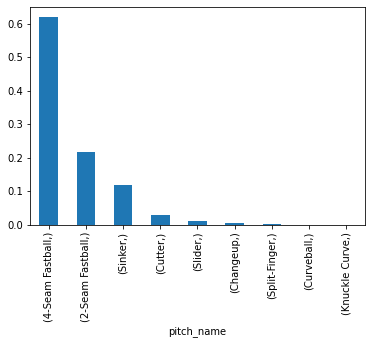

In [40]:
#print the percentages of certain pitches that are thrown at 90 mph or faster
print(rel_speed_above_90[['pitch_name']].value_counts(normalize= True))
rel_speed_above_90[['pitch_name']].value_counts(normalize= True).plot(kind = 'bar')

What is the pitch make up of the pitches move the great deal in the horizontal direction(pfx_x) or vertical direction(pfx_z)?

Side Note :

pfx_x is the horizontal movement, in inches, of the pitch between the release point and home plate,
#as compared to a theoretical pitch thrown at the same speed with no spin-induced movement

In [41]:
#now that we know what pfx_x is, lets look at its relationship with pitch_name and look at its range
print(df.pfx_x.max())
print(df.pfx_x.min())

2.93
-4.15


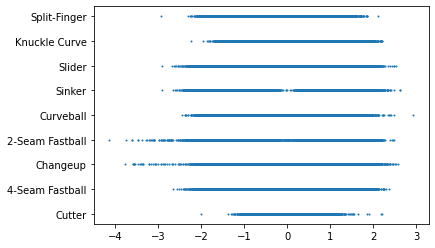

In [42]:
#lets see how the magnitude of pfx_x impacts pitch_name, generally speaking
pfx_x_col = df['pfx_x']
pitch_name_col = df['pitch_name']

plt.scatter(pfx_x_col, pitch_name_col, s=1, alpha=1)
plt.show()
#This helps us visualize where given pitches tend to end up on the pfx_x 'scale' 

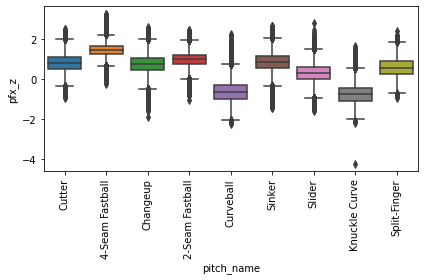

In [43]:
pfx_z_col = df['pfx_z']
pitch_name_col = df['pitch_name']
sns.boxplot(x = pitch_name_col, y = pfx_z_col )
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 90)
plt.tight_layout()
plt.show()

# vertical movenment in the pitch

In [45]:
pfx_x_above2 = df[df.pfx_x > 2]
pfx_z_above2 = df[df.pfx_z > 2]
pfx_z_below_neg1 = df[df.pfx_z < -1]

pitch_name     
Changeup           0.240157
Sinker             0.226378
2-Seam Fastball    0.173228
Slider             0.161417
4-Seam Fastball    0.072835
Knuckle Curve      0.062992
Curveball          0.057087
Cutter             0.003937
Split-Finger       0.001969
dtype: float64


<AxesSubplot:xlabel='pitch_name'>

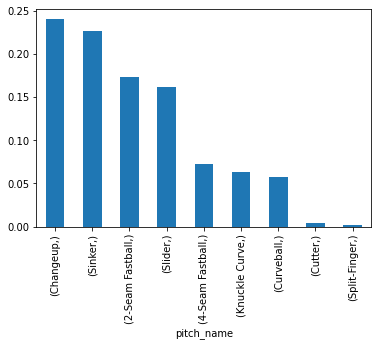

In [46]:
#all this data is for pitches with a pfx_x value of greater than 2
print(pfx_x_above2[['pitch_name']].value_counts(normalize= True))
pfx_x_above2[['pitch_name']].value_counts(normalize= True).plot(kind = 'bar')

pitch_name     
4-Seam Fastball    0.916771
Changeup           0.026402
Sinker             0.022504
2-Seam Fastball    0.016595
Cutter             0.011944
Slider             0.003646
Split-Finger       0.001634
Curveball          0.000503
dtype: float64


<AxesSubplot:xlabel='pitch_name'>

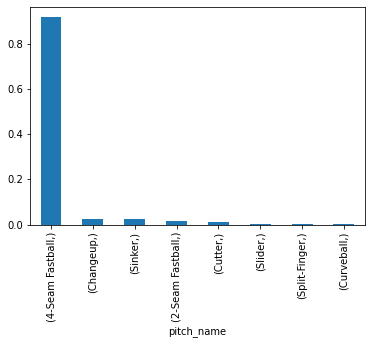

In [47]:
print(pfx_z_above2[['pitch_name']].value_counts(normalize= True))
pfx_z_above2[['pitch_name']].value_counts(normalize= True).plot(kind = 'bar')

pitch_name     
Curveball          0.648342
Knuckle Curve      0.326625
Slider             0.013979
Sinker             0.006147
Changeup           0.004858
2-Seam Fastball    0.000050
dtype: float64


<AxesSubplot:xlabel='pitch_name'>

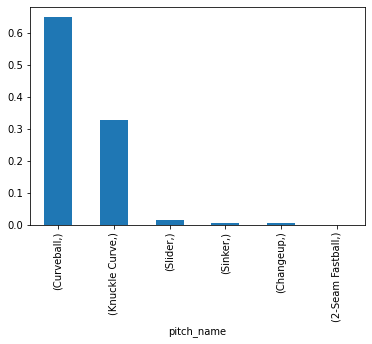

In [48]:
print(pfx_z_below_neg1[['pitch_name']].value_counts(normalize= True))
pfx_z_below_neg1[['pitch_name']].value_counts(normalize= True).plot(kind = 'bar')

What pitches associated with low spin rate and high spin rate?

In [49]:
df_sample1 = df.sample(n=1000,replace=True)

In [50]:
print(df.release_spin_rate.max())
print(df.release_spin_rate.min())

3680.0
413.0


<function matplotlib.pyplot.legend(*args, **kwargs)>

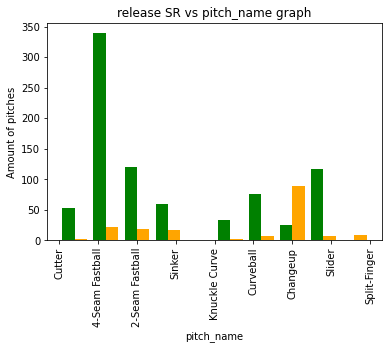

In [51]:
pitch_name_release_spin_rate_under_2000 = df_sample1[df_sample1.release_spin_rate < 2000].pitch_name
pitch_name_release_spin_rate_over_2000 = df_sample1[df_sample1.release_spin_rate > 2000].pitch_name

plt.xlabel('pitch_name')
plt.ylabel('Amount of pitches')
plt.title('release SR vs pitch_name graph')


plt.hist([pitch_name_release_spin_rate_over_2000, pitch_name_release_spin_rate_under_2000], color=['green', 'orange'], label=['RSR over 2000', 'RSR under 2000'])
plt.xticks(rotation=90)
plt.legend

In [52]:
#we see here that changeups and split-finger have very low spin rates comparatively
#this is only for our sample of 1000 pitches, but it gives us a good idea

In [53]:
#so on the mean ax value 
#(The acceleration of the pitch, in feet per second per second, in x-dimension, determined at y=50 feet)
#four all 4-seam fastballs is -4.827034304602899

In [54]:
#average 4-seam fastball velocity is 93.24 mph and 
#release_pos_z or (Vertical Release Position of the ball measured in feet from the catcher's perspective) is 5.96 feet

Does pitcher throw differently based on the opponent(hitter)?

In [55]:
player_list = df.player_name.unique()

In [57]:
len(player_list)

753

We have total 753 pitcher.

Null Hypothesis : Regardless of who the batter is, pitch throws same combination of pitch.
contraint:

    only count the batter with more than 10 pitches
    significant level = 0.05


Sale, Chris <- most inning pitch

Darvish, Yu <- had a lot of pitch types

Montas, Frankie <- throw basically fastball and slider]

In [58]:
def pitch_proportion_summary(player):
    df_pivot = df[df['player_name'] == player]
    counts_batter = df_pivot.groupby("batter")["batter"].transform(len)
    mask = (counts_batter > 10)
    df_pivot =df_pivot[mask]
    result = df_pivot.pivot_table(index = ['player_name','pitch_name'],columns = 'batter', values = 'pitch_type', aggfunc = len)
    result = result.fillna(0)
    return result

In [60]:
from scipy.stats import chi2_contingency
p_list = []
def get_p_value(name):
	result = pitch_proportion_summary(name)
	result = result.reset_index()
	info = result.iloc[:,6:]
	try:
		stat, p, dof, expected= chi2_contingency(info) 
		significance_level = 0.05
		p_list.append(p)
	except:
		pass

for player in player_list:
	get_p_value(player) 
p_list
# print(info)
# print(dof)
# print("p value: " + str(p)) 
# if p <= significance_level: 
# 	print('Reject NULL HYPOTHESIS') 
# else: 
# 	print('ACCEPT NULL HYPOTHESIS')

[0.11874548885395013,
 7.730239813223599e-08,
 0.22719032905042796,
 0.017218442535004694,
 6.282102931664955e-11,
 8.612968659309962e-09,
 0.003752115458923964,
 7.247119642543152e-07,
 0.000932181302203613,
 0.6483297714996197,
 0.42797195876757205,
 3.3318580736641144e-23,
 0.002722180454184118,
 0.763611718945311,
 2.3106109072882565e-11,
 0.00016359147040577928,
 0.007779159076587889,
 1.0754305037899628e-47,
 5.2817972450687175e-24,
 3.576204506434406e-39,
 3.914486853368607e-06,
 8.095562317194115e-06,
 0.2410013777400385,
 1.0,
 7.946733075123512e-43,
 1.0429677193238886e-06,
 3.793999003427875e-26,
 0.20481635280249438,
 0.009227635690615913,
 0.20149456646919792,
 0.006966344736202246,
 0.04048056252674145,
 2.0958938996279715e-17,
 8.276735188179502e-17,
 2.6297043876062764e-45,
 8.28653612404356e-09,
 0.010885700169237901,
 1.5524227790014687e-05,
 0.023128626969059478,
 0.00040846772413864974,
 0.06677103518741384,
 0.00910555177578513,
 0.0032498015069775533,
 3.847992190

In [63]:
significance_level = 0.05
accept = 0
reject = 0
for p in p_list:
    if p < significance_level:
        reject +=1
    else:
        accept +=1
print(f"out of {reject+accept} players, there are {reject} ({reject/500}) players that batter affect them and {accept} ({accept/500}) batter do not affect them")

out of 500 players, there are 384 (0.768) players that batter affect them and 116 (0.232) batter do not affect them


## 6. Build Model and explain the performance

build KNN model

In [64]:
X_new.columns

Index(['release_speed', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_z', 'vy0',
       'vz0', 'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'pitch_name'],
      dtype='object')

In [93]:
categorical_cols = ['batter','player_name','description']
df_model = X_new
df_model[categorical_cols] = df[categorical_cols]
df_model

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,release_speed,release_pos_z,pfx_x,pfx_z,plate_z,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,release_extension,release_pos_y,spin_axis,pitch_name,batter,player_name,description
0,91.9,5.99,-0.06,1.54,3.25,-133.402168,-4.296699,-1.171849,29.813786,-13.377620,91.0,2422.0,5.9,54.56,183.0,Cutter,595885,"Osuna, Roberto",hit_into_play
1,91.8,6.18,0.31,1.17,2.88,-133.448994,-4.998474,3.013840,26.852669,-17.455348,91.5,2415.0,6.0,54.49,164.0,Cutter,595885,"Osuna, Roberto",foul
2,94.7,6.34,-0.27,1.84,2.76,-137.339686,-7.658337,-4.705145,30.210926,-7.569305,94.2,2450.0,6.1,54.37,189.0,4-Seam Fastball,595885,"Osuna, Roberto",ball
3,82.8,6.06,-1.27,1.38,0.80,-120.061310,-8.130244,-13.056935,22.889681,-17.553809,82.6,2063.0,6.3,54.21,226.0,Changeup,595885,"Osuna, Roberto",ball
4,95.9,6.13,-1.19,1.50,0.87,-139.098671,-11.627566,-16.153705,30.503077,-10.366847,95.8,2554.0,6.3,54.17,221.0,2-Seam Fastball,595885,"Osuna, Roberto",ball
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721239,98.4,5.15,-1.28,0.68,1.83,-142.581131,-4.918857,-18.573869,33.201434,-22.306689,96.7,2066.0,5.5,54.92,246.0,2-Seam Fastball,592178,"Martínez, Carlos",called_strike
721240,84.6,5.39,1.10,-0.17,1.94,-122.821485,-1.341576,10.331882,24.074272,-33.798336,82.3,2194.0,4.7,55.68,74.0,Slider,656941,"Martínez, Carlos",hit_into_play
721241,97.3,5.18,-1.34,0.55,1.33,-141.192269,-5.944415,-18.881798,30.681296,-23.942620,96.2,2015.0,5.6,54.80,252.0,2-Seam Fastball,656941,"Martínez, Carlos",ball
721242,95.9,5.48,-1.59,0.84,2.32,-139.217803,-4.486852,-21.233172,30.974374,-20.788933,94.2,2144.0,5.5,55.07,245.0,2-Seam Fastball,656941,"Martínez, Carlos",foul


In [74]:
df_model = df_model.sample(10000, random_state= 1)

In [94]:
y = df_model.pitch_name
X = df_model.drop("pitch_name", axis = 1)

X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12345
)
y_train
X_train


release_speed  release_pos_z  pfx_x  pfx_z  plate_z         vy0  \
545935           89.7           5.32  -1.21   1.12     2.56 -129.784518   
589860           93.6           5.93  -0.72   1.63     3.81 -135.987914   
248625           89.9           5.78  -1.32   1.34     2.78 -130.100536   
136210           79.5           5.98   1.12  -0.41     2.67 -115.457018   
707452           85.3           6.35   0.14   0.22     1.42 -123.789890   
...               ...            ...    ...    ...      ...         ...   
432804           95.9           5.99   0.58   1.71     4.24 -138.997677   
88661            92.8           6.03  -0.41   1.22     1.93 -134.549198   
357452           90.1           6.08  -0.59   0.80     3.34 -131.115715   
406441           97.4           6.59  -0.76   1.27     2.88 -141.551788   
79037            86.7           6.32  -0.36   0.62     2.45 -125.993124   

             vz0         ax         ay         az  effective_speed  \
545935 -2.949230 -15.324871  29.986064 -19.548040             87.7   
589860 -3.349252 -10.557970  28.962869 -11.258341             94.2   
248625 -4.008108 -16.171831  32.117602 -16.739462             87.8   
136210  0.210653   9.033915  20.675324 -36.012735             78.3   
707452 -5.628901   0.322008  21.758185 -29.263672             83.3   
...          ...        ...        ...        ...              ...   
432804 -2.694914   9.134230  28.989415 -10.204777             94.5   
88661  -7.223053  -6.309714  27.129344 -16.311045             92.0   
357452 -2.731289  -8.567817  23.695971 -22.247468             92.1   
406441 -7.498829 -11.546210  30.962610 -13.205594             98.5   
79037  -4.238283  -3.457137  24.711594 -25.139001             85.9   

        release_spin_rate  release_extension  release_pos_y  spin_axis  \
545935             2085.0                5.6          54.89      231.0   
589860             2154.0                6.6          53.86      206.0   
248625             2242.0                5.7          54.81      228.0   
136210             2103.0                5.5          55.02       63.0   
707452             2657.0                4.8          55.65      122.0   
...                   ...                ...            ...        ...   
432804             2679.0                5.6          54.94      160.0   
88661              2069.0                5.8          54.65      201.0   
357452             2205.0                7.2          53.35      221.0   
406441             2234.0                6.9          53.60      213.0   
79037              2606.0                5.7          54.76      217.0   

        batter_112526  batter_134181  batter_136860  batter_150029  \
545935              0              0              0              0   
589860              0              0              0              0   
248625              0              0              0              0   
136210              0              0              0              0   
707452              0              0              0              0   
...               ...            ...            ...            ...   
432804              0              0              0              0   
88661               0              0              0              0   
357452              0              0              0              0   
406441              0              0              0              0   
79037               0              0              0              0   

        batter_276520  batter_282332  batter_285079  batter_400085  \
545935              0              0              0              0   
589860              0              0              0              0   
248625              0              0              0              0   
136210              0              0              0              0   
707452              0              0              0              0   
...               ...            ...            ...            ...   
432804              0              0          

In [95]:
knn_model = KNeighborsClassifier(n_neighbors=5)
# score_list = cross_val_score(knn_model,X_train,y_train, cv =5)

In [96]:
knn_model.fit(X_train,y_train)

KNeighborsClassifier()

In [100]:
X_test.iloc[0:10,:]

release_speed  release_pos_z  pfx_x  pfx_z  plate_z         vy0  \
703434           92.2           6.29  -0.48   1.80     1.70 -133.565112   
687169           85.6           5.30   0.67   0.51     2.77 -124.602632   
242515           96.2           5.46  -0.70   1.40     1.23 -139.534717   
373894           82.4           6.15   0.12  -1.13     1.06 -119.702953   
79678            74.4           5.72  -0.99   0.49     1.91 -107.945957   
401303           81.5           5.77   0.78   1.46     1.12 -118.140822   
133016           89.1           6.09   0.14   0.83     2.48 -129.456817   
394779           95.1           6.07  -0.96   1.53     3.91 -138.186491   
514251           88.6           6.74  -0.61   1.65     1.39 -128.463961   
218176           92.5           6.29  -1.10   0.51     1.92 -134.255044   

              vz0         ax         ay         az  effective_speed  \
703434  -9.649539  -6.989421  30.007665  -8.742677             91.9   
687169  -0.792613   6.831344  22.883445 -26.812881             86.4   
242515  -8.773972 -10.445065  30.432956 -12.104395             96.2   
373894  -2.959177   0.223176  20.957712 -42.412689             81.0   
79678   -1.333629  -7.230803  20.294308 -28.460621             73.1   
401303  -6.493962   8.354569  20.979020 -17.770709             80.6   
133016  -4.716406  -0.092020  25.011607 -21.782640             90.5   
394779  -3.467511 -13.770895  29.218990 -11.894905             95.6   
514251 -10.472383  -6.849576  26.274636 -11.725557             88.9   
218176  -6.406770 -14.875283  28.068682 -24.916574             92.4   

        release_spin_rate  release_extension  release_pos_y  spin_axis  \
703434             2214.0                6.4          54.05      196.0   
687169             2090.0                6.6          53.94      120.0   
242515             2378.0                6.4          54.09      209.0   
373894             2169.0                5.2          55.29        5.0   
79678              2193.0                5.7          54.82      254.0   
401303             1284.0                5.8          54.75      149.0   
133016             2351.0                7.0          53.48      169.0   
394779             2271.0                6.5          53.96      214.0   
514251             1781.0                6.7          53.85      202.0   
218176             2103.0                6.3          54.21      250.0   

        batter_112526  batter_134181  batter_136860  batter_150029  \
703434              0              0              0              0   
687169              0              0              0              0   
242515              0              0              0              0   
373894              0              0              0              0   
79678               0              0              0              0   
401303              0              0              0              0   
133016              0              0              0              0   
394779              0              0              0              0   
514251              0              0              0              0   
218176              0              0              0              0   

        batter_276520  batter_282332  batter_285079  batter_400085  \
703434              0              0              0              0   
687169              0              0              0              0   
242515              0              0              0              0   
373894              0              0              0              0   
79678               0              0              0              0   
401303              0              0              0              0   
133016              0              0              0              0   
394779              0              0              0              0   
514251              0              0              0              0   
218176              0              0              0              0   

        batter_400121  batter_400284  batte

In [101]:
y_pred = knn_model.predict(X_test.iloc[0:10,:])

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("confusion matrix")
print(confusion_matrix(y_test[0:10], y_pred))
print("classification report")
print(classification_report(y_test, y_pred))
print("accuracy score")
print(accuracy_score(y_test, y_pred))


In [102]:
import pickle
save_classifier = open("knn_classifier.pickle", "wb")
pickle.dump(knn_model, save_classifier)
save_classifier.close()

In [157]:
classifier_f = open("knn_classifier.pickle", "rb")
loaded_classifier = pickle.load(classifier_f)
classifier_f.close()

In [167]:
loaded_classifier.predict([X.iloc[0,:]])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



array(['Cutter'], dtype=object)

In [ ]:
score_list = cross_val_score(knn_model,X_train,y_train, cv =5)
print(score_list) # 5:27 
print(score_list.mean()) 

In [ ]:
y_pred = knn_model.predict(X_test)

In [ ]:
# cv_score = cross_val_score(knn_model,X_train,y_train, cv =5).mean()
# print(cv_score)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("confusion matrix")
print(confusion_matrix(y_test, y_pred))
print("classification report")
print(classification_report(y_test, y_pred))
print("accuracy score")
print(accuracy_score(y_test, y_pred))



confusion matrix
[[12881  3393   225     0    34     0  1942    41     9]
 [ 3539 44705   218     3   566     0   820   170     8]
 [  562   359 12185    19    73     9   344   306   446]
 [    2     1    38  9222    23   651     0  1114     5]
 [  126  1208   100    69  3881     7     6  2105     9]
 [    0     0    24  1068    13  2624     0   477     4]
 [ 3087  1352   280     0    25     0  6441    15    10]
 [  120   476   411  1101  1535   317     8 17088    63]
 [   38    26   665     5    19    12     9    98  1292]]
classification report
                 precision    recall  f1-score   support

2-Seam Fastball       0.63      0.70      0.66     18525
4-Seam Fastball       0.87      0.89      0.88     50029
       Changeup       0.86      0.85      0.86     14303
      Curveball       0.80      0.83      0.82     11056
         Cutter       0.63      0.52      0.57      7511
  Knuckle Curve       0.72      0.62      0.67      4210
         Sinker       0.67      0.57      0.62 

**Recall** : The ability of a model to find all the relevant cases within a data set. Mathematically, we define recall as the number of true positives divided by the number of true positives plus the number of false negatives. (out of 1,000 true value how many has been predicted correctly)

**Precision** : The ability of a classification model to identify only the relevant data points. Mathematically, precision the number of true positives divided by the number of true positives plus the number of false positives (out of 1,000 predicted value, how many are true prediction)

We will use just 4-seam fastball pitch_name to explain these concepts.

For recall: True positives are data points classified as positive by the model that actually are positive (meaning they are correct), and false negatives are data points the model identifies as negative that actually are positive (incorrect). In our model's case, if we are looking at 4-seam fastball for example, true positives are correctly identified 4-seam fastballs and false negatives would be pitches that the model labels as not 4-seam fastballs that actually were 4-seam fastballs. In other words, recall can be thought of as a model’s ability to find all the data points of the class in which we are interested in a data set.

Precision and recall have an inverse relationship, as one goes down the other goes up and vice-versa.

Precision is the number of true positives divided by the number of true positives plus the number of false positives. False positives are cases the model incorrectly labels as positive that are actually negative, or in our example, pitches the model classifies as 4-seam fastballs that are not. While recall expresses the ability to find all relevant instances of a class in a data set, precision expresses the proportion of the data points our model says existed in the relevant class that were indeed relevant.

**The F1 score** is the harmonic mean of precision and recall, taking both metrics into account in the following equation: f1_score = 2(precisionrecall)/(precision+recall)

This harmonic mean punishes extreme values of precision or recall and a high f1 scoremeans we have maximized the the optimal balance of recall and precision in our model.

KNN model is quiet slow for this case. So based on the scikit learn algorithm cheat sheet, since our data has more than 100k of data point, we proceed with SGD Classifier.